# Diffusion Model

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import os
import PIL
import numpy as np
import torchvision.utils as vutils

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformation for KNEEMRI dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image
    transforms.ToTensor(),  # Convert to tensor
])

# Load KNEEMRI dataset
train_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/knee-mri/Knee MRI/train', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/knee-mri/Knee MRI/train', transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/knee-mri/Knee MRI/val', transform=transform)

# Define data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

# Define UNet architecture
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 128x128
        )
        # Middle
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 64x64
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2),  # 128x128
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),  # 256x256
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        x3 = self.decoder(x2)
        return x3

# Define diffusion model
class DiffusionModel(nn.Module):
    def __init__(self, channels=3):
        super(DiffusionModel, self).__init__()
        self.channels = channels

    def forward(self, x, t, device):
        # Simulate diffusion process by adding Gaussian noise to the input image
        noise = torch.randn_like(x) * (1 / (t + 1)) ** 0.5  # Scale noise by the square root of time step
        diffused_x = x + noise
        return diffused_x

# Combine UNet with Diffusion model
class DiffusionUNet(nn.Module):
    def __init__(self, diffusion_model, unet_model):
        super(DiffusionUNet, self).__init__()
        self.diffusion_model = diffusion_model
        self.unet_model = unet_model

    def forward(self, x, t, device):
        x_t = self.diffusion_model(x, t, device)
        denoised_x = self.unet_model(x_t)
        return denoised_x

# Function to save image
def save_image(tensor, filename):
    grid = vutils.make_grid(tensor, nrow=1, padding=0)
    ndarr = grid.mul(0.5).add(0.5).mul(255).clamp(0, 255).byte().cpu().permute(1, 2, 0).numpy()
    im = PIL.Image.fromarray(ndarr)
    im.save(filename)

# Create instances of the UNet and Diffusion models
unet_model = UNet().to(device)
diffusion_model = DiffusionModel().to(device)

# Define training function for UNet model
def train_unet_model(model, train_loader, num_epochs=4000):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        for i, (images, _) in enumerate(train_loader):
            images = images.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, images)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    return model

# Train the UNet model
trained_unet_model = train_unet_model(unet_model, train_loader)

# Combine UNet with Diffusion model
diffusion_unet_model = DiffusionUNet(diffusion_model, trained_unet_model)

# Save trained UNet model
torch.save(trained_unet_model.state_dict(), 'unet_model.pth')


Epoch 1/4000, Loss: 0.0331
Epoch 2/4000, Loss: 0.0160
Epoch 3/4000, Loss: 0.0141
Epoch 4/4000, Loss: 0.0127
Epoch 5/4000, Loss: 0.0116
Epoch 6/4000, Loss: 0.0107
Epoch 7/4000, Loss: 0.0101
Epoch 8/4000, Loss: 0.0097
Epoch 9/4000, Loss: 0.0095
Epoch 10/4000, Loss: 0.0097
Epoch 11/4000, Loss: 0.0087
Epoch 12/4000, Loss: 0.0085
Epoch 13/4000, Loss: 0.0080
Epoch 14/4000, Loss: 0.0088
Epoch 15/4000, Loss: 0.0083
Epoch 16/4000, Loss: 0.0072
Epoch 17/4000, Loss: 0.0070
Epoch 18/4000, Loss: 0.0069
Epoch 19/4000, Loss: 0.0067
Epoch 20/4000, Loss: 0.0069
Epoch 21/4000, Loss: 0.0062
Epoch 22/4000, Loss: 0.0061
Epoch 23/4000, Loss: 0.0062
Epoch 24/4000, Loss: 0.0056
Epoch 25/4000, Loss: 0.0055
Epoch 26/4000, Loss: 0.0055
Epoch 27/4000, Loss: 0.0055
Epoch 28/4000, Loss: 0.0052
Epoch 29/4000, Loss: 0.0050
Epoch 30/4000, Loss: 0.0049
Epoch 31/4000, Loss: 0.0048
Epoch 32/4000, Loss: 0.0067
Epoch 33/4000, Loss: 0.0054
Epoch 34/4000, Loss: 0.0048
Epoch 35/4000, Loss: 0.0044
Epoch 36/4000, Loss: 0.0043
E

In [6]:
def generate_synthetic_images(loader, diffusion_model, dataset_name, num_images_per_class):
    output_dir = os.path.join("/kaggle/working/", dataset_name)
    os.makedirs(output_dir, exist_ok=True)

    # Create subdirectories for normal and acl images
    normal_dir = os.path.join(output_dir, "normal")
    acl_dir = os.path.join(output_dir, "acl")
    os.makedirs(normal_dir, exist_ok=True)
    os.makedirs(acl_dir, exist_ok=True)

    diffusion_model.eval()

    normal_images_generated = 0
    acl_images_generated = 0

    while normal_images_generated < num_images_per_class or acl_images_generated < num_images_per_class:
        for i, (images, labels) in enumerate(loader):
            if normal_images_generated >= num_images_per_class and acl_images_generated >= num_images_per_class:
                break

            images = images.to(device)

            # Generate synthetic image using the diffusion process
            timesteps = 300  # Example number of diffusion timesteps
            t = torch.randint(0, timesteps, (1,)).to(device)
            synthetic_image = diffusion_model(images, t, device)

            # Determine subdirectory based on label
            label_dir = normal_dir if labels.item() == 0 else acl_dir

            if labels.item() == 0 and normal_images_generated < num_images_per_class:
                save_image(synthetic_image, os.path.join(label_dir, f"{normal_images_generated}.png"))
                normal_images_generated += 1

            elif labels.item() == 1 and acl_images_generated < num_images_per_class:
                save_image(synthetic_image, os.path.join(label_dir, f"{acl_images_generated}.png"))
                acl_images_generated += 1

    print(f"Generated {normal_images_generated} normal images and {acl_images_generated} acl images for {dataset_name} dataset.")

# Generate synthetic images with specified number of images per class and per dataset split
generate_synthetic_images(train_loader, diffusion_unet_model, "train", num_images_per_class=400)
generate_synthetic_images(test_loader, diffusion_unet_model, "test", num_images_per_class=300)
generate_synthetic_images(val_loader, diffusion_unet_model, "validation", num_images_per_class=200)

Generated 400 normal images and 400 acl images for train dataset.
Generated 300 normal images and 300 acl images for test dataset.
Generated 200 normal images and 200 acl images for validation dataset.


# Generated Images

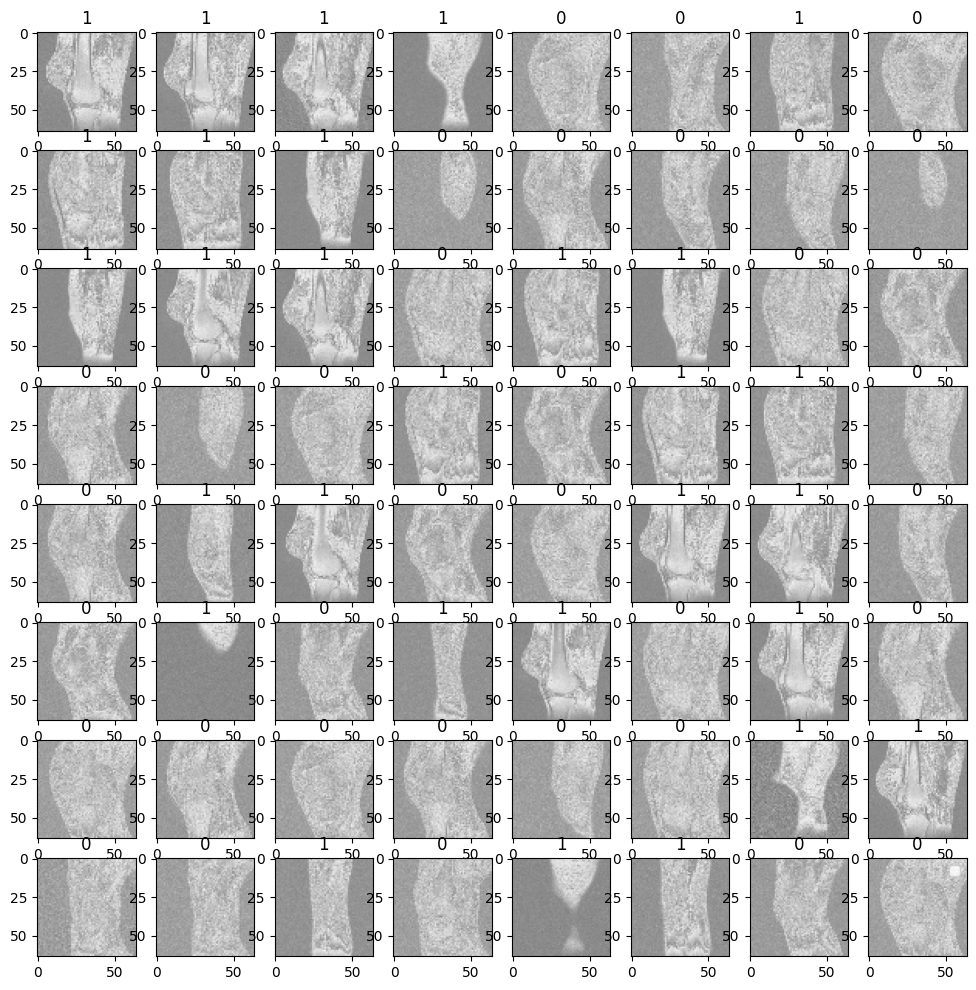

In [8]:
import pathlib
import matplotlib.pyplot as plt
import cv2
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.*')))
    def readImages(self,):
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img))
                img = cv2.resize(img , self.image_shape)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img  = img/255
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels
readDatasetObject = ReadDataset('/kaggle/working/train/',
                               ['normal', 'acl'],
                               (64, 64))
images, labels = readDatasetObject.readImages()
images.shape, labels.shape
plt.figure(figsize = (12, 12))
indexs = np.random.randint(0, len(labels), size = (64, ))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(images[indexs[i]])
    plt.title(labels[indexs[i]])
plt.legend()

# 2D images in 3D view

In [9]:
pip install numpy nibabel pillow


Note: you may need to restart the kernel to use updated packages.


3D volume part 1 saved to /kaggle/working/3d_volume_part1.nii


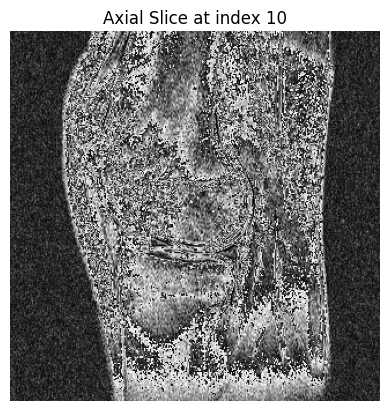

3D volume saved to /kaggle/working/3d_volume.nii


In [10]:
import os
import numpy as np
from PIL import Image
import nibabel as nib
import matplotlib.pyplot as plt

def load_slices_from_directory(directory):
    # Get list of .png file names in the directory
    files = sorted([f for f in os.listdir(directory) if f.endswith('.png')])
    
    if not files:
        raise ValueError(f"No .png files found in directory: {directory}")
    
    slices = []
    
    # Load each .png file and extract 2D slices
    for file in files:
        img = Image.open(os.path.join(directory, file)).convert('L')  # Convert to grayscale
        data = np.array(img)
        if data.ndim != 2:
            raise ValueError(f"Expected 2D arrays in .png files, but found array with shape {data.shape} in file {file}")
        slices.append(data)
    
    return np.array(slices)

def save_volume_as_nifti(volume, output_path):
    max_slices = 5000  # Maximum number of slices per NIfTI file
    total_slices = volume.shape[-1]
    num_files = (total_slices // max_slices) + 1

    for i in range(num_files):
        start_slice = i * max_slices
        end_slice = min(start_slice + max_slices, total_slices)
        volume_chunk = volume[:, :, start_slice:end_slice]
        
        # Create a NIfTI image
        nifti_img = nib.Nifti1Image(volume_chunk, affine=np.eye(4))
        
        # Save the NIfTI image to a file
        chunk_output_path = f"{os.path.splitext(output_path)[0]}_part{i+1}.nii"
        nib.save(nifti_img, chunk_output_path)
        print(f'3D volume part {i+1} saved to {chunk_output_path}')

def visualize_single_slice(volume, slice_index, axis=0):
    if axis == 0:
        slice_img = volume[slice_index, :, :]
        plane = 'Sagittal'
    elif axis == 1:
        slice_img = volume[:, slice_index, :]
        plane = 'Coronal'
    elif axis == 2:
        slice_img = volume[:, :, slice_index]
        plane = 'Axial'
    else:
        raise ValueError("Invalid axis value. It should be 0, 1, or 2.")
    
    plt.imshow(slice_img, cmap='gray')
    plt.title(f'{plane} Slice at index {slice_index}')
    plt.axis('off')
    plt.show()

# Example usage:
directory = '/kaggle/input/knee-mri/Knee MRI/train/Normal'  
output_file_name = '3d_volume.nii'
output_path = os.path.join('/kaggle/working/', output_file_name)

# Load the slices and create the 3D volume
slices = load_slices_from_directory(directory)

# Stack slices to create a 3D volume
volume = np.stack(slices, axis=-1)

# Save the 3D volume as NIfTI files
save_volume_as_nifti(volume, output_path)

# Visualize a specific slice
slice_index = 10  # Change this to the slice index you want to visualize
axis = 2  
visualize_single_slice(volume, slice_index, axis)

print(f'3D volume saved to {output_path}')


3D volume part 1 saved to /kaggle/working/3d_volume_part1.nii


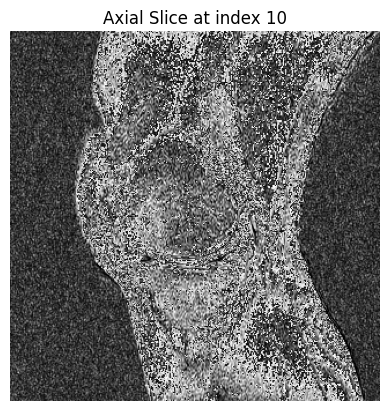

3D volume saved to /kaggle/working/3d_volume.nii


In [11]:
import os
import numpy as np
from PIL import Image
import nibabel as nib
import matplotlib.pyplot as plt

def load_slices_from_directory(directory):
    # Get list of .png file names in the directory
    files = sorted([f for f in os.listdir(directory) if f.endswith('.png')])
    
    if not files:
        raise ValueError(f"No .png files found in directory: {directory}")
    
    slices = []
    
    # Load each .png file and extract 2D slices
    for file in files:
        img = Image.open(os.path.join(directory, file)).convert('L')  # Convert to grayscale
        data = np.array(img)
        if data.ndim != 2:
            raise ValueError(f"Expected 2D arrays in .png files, but found array with shape {data.shape} in file {file}")
        slices.append(data)
    
    return np.array(slices)

def save_volume_as_nifti(volume, output_path):
    max_slices = 5000  # Maximum number of slices per NIfTI file
    total_slices = volume.shape[-1]
    num_files = (total_slices // max_slices) + 1

    for i in range(num_files):
        start_slice = i * max_slices
        end_slice = min(start_slice + max_slices, total_slices)
        volume_chunk = volume[:, :, start_slice:end_slice]
        
        # Create a NIfTI image
        nifti_img = nib.Nifti1Image(volume_chunk, affine=np.eye(4))
        
        # Save the NIfTI image to a file
        chunk_output_path = f"{os.path.splitext(output_path)[0]}_part{i+1}.nii"
        nib.save(nifti_img, chunk_output_path)
        print(f'3D volume part {i+1} saved to {chunk_output_path}')

def visualize_single_slice(volume, slice_index, axis=2):
    if axis == 0:
        slice_img = volume[slice_index, :, :]
        plane = 'Sagittal'
    elif axis == 1:
        slice_img = volume[:, slice_index, :]
        plane = 'Coronal'
    elif axis == 2:
        slice_img = volume[:, :, slice_index]
        plane = 'Axial'
    else:
        raise ValueError("Invalid axis value. It should be 0, 1, or 2.")
    
    plt.imshow(slice_img, cmap='gray')
    plt.title(f'{plane} Slice at index {slice_index}')
    plt.axis('off')
    plt.show()

# Example usage:
directory = '/kaggle/input/knee-mri/Knee MRI/train/Acl'  
output_file_name = '3d_volume.nii'
output_path = os.path.join('/kaggle/working/', output_file_name)

# Load the slices and create the 3D volume
slices = load_slices_from_directory(directory)

# Stack slices to create a 3D volume
volume = np.stack(slices, axis=-1)

# Save the 3D volume as NIfTI files
save_volume_as_nifti(volume, output_path)

# Visualize a specific slice
slice_index = 10  # Change this to the slice index you want to visualize
axis = 2  # Change this to the desired axis (0 for sagittal, 1 for coronal, 2 for axial)
visualize_single_slice(volume, slice_index, axis)

print(f'3D volume saved to {output_path}')


In [12]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, fixed

def load_png_files(directory):
    # Get list of .png file names in the directory
    files = sorted([f for f in os.listdir(directory) if f.endswith('.png')])
    
    if not files:
        raise ValueError(f"No .png files found in directory: {directory}")
    
    slices = []
    
    # Load each .png file and extract 2D slices
    for file in files:
        img = Image.open(os.path.join(directory, file)).convert('L')  # Convert to grayscale
        data = np.array(img)
        if data.ndim != 2:
            raise ValueError(f"Expected 2D arrays in .png files, but found array with shape {data.shape} in file {file}")
        slices.append(data)
    
    return np.array(slices)

def explore_3dimage(image, layer):
    plt.figure(figsize=(10, 5))
    
    slice_img = image[layer, :, :]
    plane = 'Sagittal'
    
    plt.imshow(slice_img, cmap='gray')
    plt.title(f'{plane} Slice at index {layer}', fontsize=20)
    plt.axis('off')
    plt.show()

# Example usage:
directory = '/kaggle/input/knee-mri/Knee MRI/train/Normal'  # Update this with the path to your .png files

# Load the .png files and create the 3D volume
slices = load_png_files(directory)

# Stack slices to create a 3D volume
volume = np.stack(slices, axis=0)

# Create widgets
layer_widget = widgets.IntSlider(min=0, max=volume.shape[0] - 1, step=1, value=0, description='Layer:')

# Interactive display
interactive_plot = interact(explore_3dimage, image=fixed(volume), layer=layer_widget)
display(interactive_plot)


interactive(children=(IntSlider(value=0, description='Layer:', max=34), Output()), _dom_classes=('widget-inter…

<function __main__.explore_3dimage(image, layer)>

In [13]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, fixed

def load_png_files(directory):
    # Get list of .png file names in the directory
    files = sorted([f for f in os.listdir(directory) if f.endswith('.png')])
    
    if not files:
        raise ValueError(f"No .png files found in directory: {directory}")
    
    slices = []
    
    # Load each .png file and extract 2D slices
    for file in files:
        img = Image.open(os.path.join(directory, file)).convert('L')  # Convert to grayscale
        data = np.array(img)
        if data.ndim != 2:
            raise ValueError(f"Expected 2D arrays in .png files, but found array with shape {data.shape} in file {file}")
        slices.append(data)
    
    return np.array(slices)

def explore_3dimage(image, layer):
    plt.figure(figsize=(10, 5))
    
    slice_img = image[layer, :, :]
    plane = 'Sagittal'
    
    plt.imshow(slice_img, cmap='gray')
    plt.title(f'{plane} Slice at index {layer}', fontsize=20)
    plt.axis('off')
    plt.show()

# Example usage:
directory = '/kaggle/input/knee-mri/Knee MRI/train/Acl'  # Update this with the path to your .png files

# Load the .png files and create the 3D volume
slices = load_png_files(directory)

# Stack slices to create a 3D volume
volume = np.stack(slices, axis=0)

# Create widgets
layer_widget = widgets.IntSlider(min=0, max=volume.shape[0] - 1, step=1, value=0, description='Layer:')

# Interactive display
interactive_plot = interact(explore_3dimage, image=fixed(volume), layer=layer_widget)
display(interactive_plot)


interactive(children=(IntSlider(value=0, description='Layer:', max=34), Output()), _dom_classes=('widget-inter…

<function __main__.explore_3dimage(image, layer)>

# Prediction Using Few-Shot Techniques

**ACL Image**

2024-06-29 14:13:23.699321: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 14:13:23.699431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 14:13:23.794687: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
Step 0, Loss: 4.1782732009887695
Epoch 2/20
Step 0, Loss: 0.8433442115783691
Epoch 3/20
Step 0, Loss: 1.1242445707321167
Epoch 4/20
Step 0, Loss: 0.6272303462028503
Epoch 5/20
Step 0, Loss: 0.8902956247329712
Epoch 6/20
Step 0, Loss: 0.4785165786743164
Epoch 7/20
Step 0, Loss: 0.4403456747531891
Epoch 8/20
Step 0, Loss: 0.6263809204101562
Epoch 9/20
Step 0, Loss: 0.3698115944862366
Epoch 10/20
Step 0, Loss: 0.3667943775653839
Epoch 11/20
Step 0, Loss: 0.35032036900520325
Epoch 12/20
Step 0, Loss: 0.22959718108177185
Epoch 13/20
Step 0, Loss: 0.24295508861541748
Epoch 14/20
Step 0, Loss: 0.14601612091064453
Epoch 15/20
Step 0, Loss: 0.1002311110496521
Epoch 16/20
Step 0, Loss: 0.10742562264204025
Epoch 17/20
Step 0, Loss: 0.04854179546236992
Epoch 18/20
Step 0, Loss: 0.030842212960124016
Epoch 19/20
Step 0, Loss: 0.030283033847808838
Epoch 20/20
Step 0, Loss: 0.013181345537304878
The uploaded MRI scan is classified as: Normal


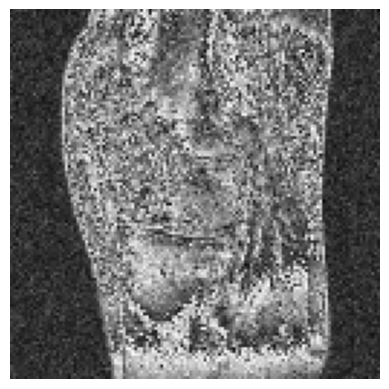

In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

# Load and preprocess the MRI dataset
def load_mri_data(data_dir, img_size=(128, 128)):
    data = []
    labels = []

    for label_dir in ['Normal', 'Acl']:
        label = 0 if label_dir == 'Normal' else 1
        label_path = os.path.join(data_dir, label_dir)
        for filename in os.listdir(label_path):
            if filename.endswith('.png'):
                img_path = os.path.join(label_path, filename)
                img = load_img(img_path, target_size=img_size, color_mode='grayscale')
                img_array = img_to_array(img)
                data.append(img_array)
                labels.append(label)

    data = np.array(data, dtype='float32') / 255.0
    labels = np.array(labels, dtype='int32')
    return data, labels

data_dir = '/kaggle/input/knee-mri/Knee MRI/test'
data, labels = load_mri_data(data_dir)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

class PrototypicalNetwork(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(PrototypicalNetwork, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(embedding_dim)
        ])

    def call(self, inputs):
        return self.encoder(inputs)

def euclidean_distance(a, b):
    return tf.sqrt(tf.reduce_sum(tf.square(a - b), axis=-1))

def compute_prototypes(support_set, support_labels, num_classes, embedding_dim, model):
    prototypes = []
    for cls in range(num_classes):
        cls_samples = support_set[support_labels == cls]
        cls_embeddings = model.encoder(cls_samples)
        cls_prototype = tf.reduce_mean(cls_embeddings, axis=0)
        prototypes.append(cls_prototype)
    return tf.stack(prototypes)

def train_prototypical_network(X_train, y_train, num_classes, embedding_dim, num_epochs=20, batch_size=16):
    model = PrototypicalNetwork(embedding_dim)
    optimizer = optimizers.Adam(learning_rate=0.001)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            with tf.GradientTape() as tape:
                embeddings = model(X_batch)
                loss = loss_fn(y_batch, embeddings)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            if i % 100 == 0:
                print(f'Step {i}, Loss: {loss.numpy()}')

    # Compute prototypes after training
    prototypes = compute_prototypes(X_train, y_train, num_classes, embedding_dim, model)

    return model, prototypes

# Hyperparameters
embedding_dim = 64
num_classes = 2

# Train the model and get prototypes
model, prototypes = train_prototypical_network(X_train, y_train, num_classes, embedding_dim)

def classify_mri_scan(model, img_path, prototypes, img_size=(128, 128)):
    img = load_img(img_path, target_size=img_size, color_mode='grayscale')
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    img_embedding = model.encoder(img_array)
    distances = euclidean_distance(img_embedding, prototypes)
    predicted_label = tf.argmin(distances, axis=-1).numpy()

    label_map = {0: 'Normal', 1: 'Acl'}
    predicted_label_name = label_map[predicted_label]

    return predicted_label_name, img_array

# Example usage
img_path = '/kaggle/working/train/acl/185.png'
classification_result, img_array = classify_mri_scan(model, img_path, prototypes)

# Print classification result
print(f'The uploaded MRI scan is classified as: {classification_result}')

# Plot the MRI scan
import matplotlib.pyplot as plt
plt.imshow(np.squeeze(img_array), cmap='gray')
plt.axis('off')
plt.show()


**Normal Image**

Epoch 1/20
Step 0, Loss: 4.227078437805176
Epoch 2/20
Step 0, Loss: 1.3645814657211304
Epoch 3/20
Step 0, Loss: 0.9468637704849243
Epoch 4/20
Step 0, Loss: 0.6334434151649475
Epoch 5/20
Step 0, Loss: 1.075188159942627
Epoch 6/20
Step 0, Loss: 0.5591926574707031
Epoch 7/20
Step 0, Loss: 0.8056317567825317
Epoch 8/20
Step 0, Loss: 0.40025368332862854
Epoch 9/20
Step 0, Loss: 0.3933902084827423
Epoch 10/20
Step 0, Loss: 0.4763143062591553
Epoch 11/20
Step 0, Loss: 0.30443257093429565
Epoch 12/20
Step 0, Loss: 0.3641815483570099
Epoch 13/20
Step 0, Loss: 0.20424269139766693
Epoch 14/20
Step 0, Loss: 0.16290214657783508
Epoch 15/20
Step 0, Loss: 0.20557072758674622
Epoch 16/20
Step 0, Loss: 0.10762278735637665
Epoch 17/20
Step 0, Loss: 0.08450180292129517
Epoch 18/20
Step 0, Loss: 0.09490988403558731
Epoch 19/20
Step 0, Loss: 0.04518572986125946
Epoch 20/20
Step 0, Loss: 0.026308737695217133
The uploaded MRI scan is classified as: Normal


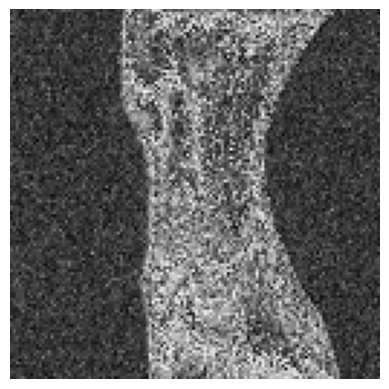

In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

# Load and preprocess the MRI dataset
def load_mri_data(data_dir, img_size=(128, 128)):
    data = []
    labels = []

    for label_dir in ['Normal', 'Acl']:
        label = 0 if label_dir == 'Normal' else 1
        label_path = os.path.join(data_dir, label_dir)
        for filename in os.listdir(label_path):
            if filename.endswith('.png'):
                img_path = os.path.join(label_path, filename)
                img = load_img(img_path, target_size=img_size, color_mode='grayscale')
                img_array = img_to_array(img)
                data.append(img_array)
                labels.append(label)

    data = np.array(data, dtype='float32') / 255.0
    labels = np.array(labels, dtype='int32')
    return data, labels

data_dir = '/kaggle/input/knee-mri/Knee MRI/test'
data, labels = load_mri_data(data_dir)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

class PrototypicalNetwork(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(PrototypicalNetwork, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(embedding_dim)
        ])

    def call(self, inputs):
        return self.encoder(inputs)

def euclidean_distance(a, b):
    return tf.sqrt(tf.reduce_sum(tf.square(a - b), axis=-1))

def compute_prototypes(support_set, support_labels, num_classes, embedding_dim):
    prototypes = []
    for cls in range(num_classes):
        cls_samples = support_set[support_labels == cls]
        cls_embeddings = model.encoder(cls_samples)
        cls_prototype = tf.reduce_mean(cls_embeddings, axis=0)
        prototypes.append(cls_prototype)
    return tf.stack(prototypes)

def train_prototypical_network(X_train, y_train, num_classes, embedding_dim, num_epochs=20, batch_size=16):
    model = PrototypicalNetwork(embedding_dim)
    optimizer = optimizers.Adam(learning_rate=0.001)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            with tf.GradientTape() as tape:
                embeddings = model(X_batch)
                loss = loss_fn(y_batch, embeddings)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            if i % 100 == 0:
                print(f'Step {i}, Loss: {loss.numpy()}')

    return model

# Hyperparameters
embedding_dim = 64
num_classes = 2

# Train the model
model = train_prototypical_network(X_train, y_train, num_classes, embedding_dim)

from tensorflow.keras.preprocessing.image import img_to_array, load_img

def classify_mri_scan(model, img_path, prototypes, img_size=(128, 128)):
    img = load_img(img_path, target_size=img_size, color_mode='grayscale')
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    img_embedding = model.encoder(img_array)
    distances = euclidean_distance(img_embedding, prototypes)
    predicted_label = tf.argmin(distances, axis=-1).numpy()

    label_map = {0: 'Normal', 1: 'Acl'}
    predicted_label_name = label_map[predicted_label]

    return predicted_label_name, img_array

# Example usage
img_path = '/kaggle/working/train/normal/195.png'
classification_result, img_array = classify_mri_scan(model, img_path, prototypes)

# Print classification result
print(f'The uploaded MRI scan is classified as: {classification_result}')

# Plot the MRI scan
import matplotlib.pyplot as plt
plt.imshow(np.squeeze(img_array), cmap='gray')
plt.axis('off')
plt.show()